In [1]:
import json, os, math, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [44]:
TRAINING = '/Users/user/data/research/proton-deuteron/ssvd/handpicked_d.pkl'

# TRAINING

In [75]:
IMG_H, IMG_W = 64, 96                   # TODO: NEED TO PRESERVE A SENSE OF LENGTH PROPERLY

BATCH_SIZE = 128
FEAT_DIM = 128
LR = 3e-4
EPOCHS = 10
WEIGHT_DECAY = 1e-4                     # Learn about

PCT_THR = 80                             # PERCENTILE THRESHOLD FOR DEFINING DEUTERONS IN FEATURE SPACE

SEED = 0

OUT_DIR = "artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

In [66]:
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.mps.manual_seed(SEED)

In [67]:
class DeutTrain(Dataset):
    def __init__(self, df, global_max_adc):
        self.df = df.reset_index(drop=True)
        self.gmax = float(global_max_adc)

    def __len__(self):
        return len(self.df)
    
    def _to_fixed(self, img):
        # TODO: NEED TO PRESERVE A SENSE OF LENGTH PROPERLY
        h, w, = img.shape
        out = np.zeros((IMG_H, IMG_W), dtype=np.float32)
        h0 = min(h, IMG_H)
        w0 = min(w, IMG_W)
        out[:h0, :w0] = img[:h0, :w0]
        return out
    
    def __getitem__(self, i):
        arr = np.asarray(self.df.loc[i, 'image_intensity'], dtype=np.float32)
        x = self._to_fixed(arr)

        ch0 = x / (self.gmax + 1e-6)
        
        mu, sd = float(x.mean()), float(x.std())
        if sd < 1e-6: sd = 1e-6
        ch1 = (x - mu) / sd

        x2 = np.stack([ch0, ch1], axis=0)                                           # (2, H, W)

        return torch.from_numpy(x2)

In [68]:
class DeutNet(nn.Module):
    def __init__(self, in_ch=2, feat_dim=FEAT_DIM):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
        )
        self.fc = nn.Linear(64, feat_dim)

    def forward(self, x):
        x = self.conv(x)
        x = F.adaptive_avg_pool2d(x, 1).flatten(1)
        return self.fc(x)

In [69]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print('Device:', device)

print('Loading training dataset:', TRAINING)
df = pd.read_pickle(TRAINING)

global_max_adc = 2342.0                                                         # or try 1713.0 from the training data

print('Global max ADC:', global_max_adc)

ds = DeutTrain(df, global_max_adc)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

model = DeutNet().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

Device: mps
Loading training dataset: /Users/user/data/research/proton-deuteron/ssvd/handpicked_d.pkl
Global max ADC: 2342.0


In [70]:
model.eval()
feats = []
with torch.no_grad():
    for batch in tqdm(dl, desc='Init centre'):
        batch = batch.to(device, non_blocking=True)
        feats.append(model(batch))

feats = torch.cat(feats, dim=0)
centre = feats.mean(dim=0).detach()

Init centre:   0%|          | 0/5 [00:00<?, ?it/s]/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Init centre: 100%|██████████| 5/5 [00:00<00:00, 157.42it/s]


In [71]:
for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    n = 0
    for batch in dl:
        batch = batch.to(device, non_blocking=True)
        f = model(batch)
        loss = ((f - centre) ** 2).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        bs = batch.size(0)
        running += loss.item() * bs
        n += bs
    print(f'Epoch {epoch:03d}/{EPOCHS} loss={running/n:.8f}')

Epoch 001/10 loss=0.00000609
Epoch 002/10 loss=0.00000501
Epoch 003/10 loss=0.00000387
Epoch 004/10 loss=0.00000317
Epoch 005/10 loss=0.00000253
Epoch 006/10 loss=0.00000222
Epoch 007/10 loss=0.00000190
Epoch 008/10 loss=0.00000162
Epoch 009/10 loss=0.00000144
Epoch 010/10 loss=0.00000129


In [76]:
model.eval()
train_dists = []
with torch.no_grad():
    for batch in DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False):
        batch = batch.to(device)
        d = torch.norm(model(batch) - centre, dim=1)
        train_dists.extend(d.cpu().numpy())
    train_dists = np.asarray(train_dists, dtype=np.float32)

    thr = float(np.percentile(train_dists, PCT_THR))
    print(f'Chosen threshold @ P{PCT_THR:.1f} = {thr:.6f}')

Chosen threshold @ P80.0 = 0.013090


In [77]:
torch.save(model.state_dict(), os.path.join(OUT_DIR, 'svdd.pt'))
np.save(os.path.join(OUT_DIR, 'centre.npy'), centre.detach().cpu().numpy())
meta = {
    'img_h': IMG_H, 'img_w': IMG_W,
    'feat_dim': FEAT_DIM,
    'global_max_adc': float(global_max_adc),
    'threshold': thr,
    'percentile': PCT_THR,
    'seed': SEED
}
with open(os.path.join(OUT_DIR, 'threshold.json'), 'w') as f:
    json.dump(meta, f, indent=2)
print('Saved to', OUT_DIR)

Saved to artifacts


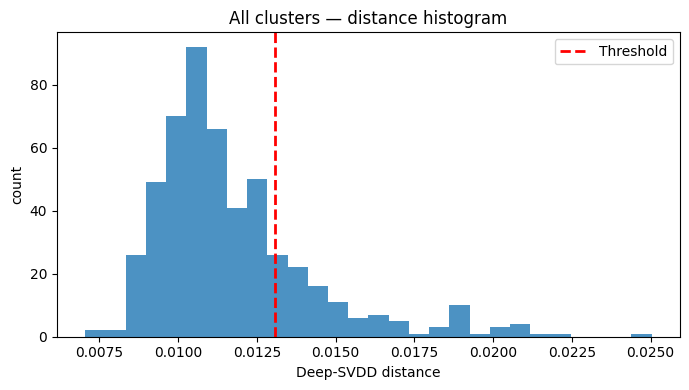

In [78]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# If df is already in memory with the column "score"
scores = train_dists.astype(float)

# bins = np.linspace(scores.min(), np.percentile(scores, 99.9), 200)

plt.figure(figsize=(7,4))
plt.hist(scores, bins='auto', alpha=0.8)
plt.axvline(thr, ls="--", lw=2, color='r', label='Threshold')
plt.xlabel("Deep-SVDD distance")
plt.ylabel("count")
plt.title("All clusters — distance histogram")
plt.legend()
plt.tight_layout(); plt.show()


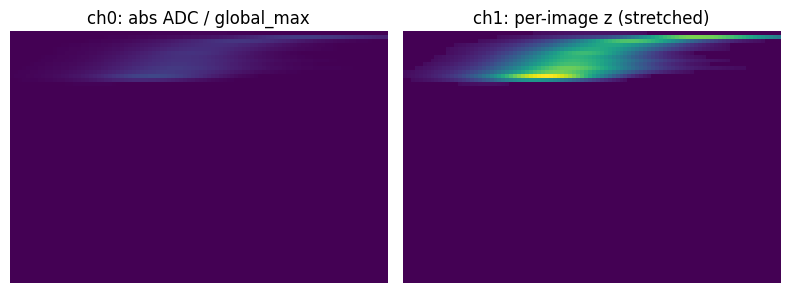

In [31]:
i = 0                      # random.randint(0, 500)  
x = ds[i]                 # shape: (2, H, W), on CPU
ch0 = x[0].numpy()
ch1 = x[1].numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Channel 0: scaled absolute ADC
axs[0].imshow(ch0, vmin=0.0, vmax=1.0)
axs[0].set_title("ch0: abs ADC / global_max")
axs[0].axis("off")

# Channel 1: z-score (stretch to [0,1] for display only)
z = ch1
z_disp = (z - z.min()) / (z.max() - z.min() + 1e-6)
axs[1].imshow(z_disp)
axs[1].set_title("ch1: per-image z (stretched)")
axs[1].axis("off")

plt.tight_layout()
plt.show()